##### **Versions des librairies utilisées dans ce Notebook :**  

Python: 3.9.7  

numpy: 1.26.4  
pandas: 2.2.2  
matplotlib: 3.9.0  
sklearn: 1.5.1  
IPython: 8.15.0  
category_encoders: 2.6.3

---

In [ ]:
# importation des librairies
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt

In [ ]:
# librairies spécifiques sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit

## Etape 2 : Développement et simulation d'un premier modèle

Import des données dans un dataframe :

In [ ]:
energy_df = pd.read_csv('data/cleaned/energy_df.csv', index_col=0)

### 2.1 - Préparation des données :

In [ ]:
energy_df.head()

---
#### 2.1.1 - Séparation de la cible et des features

In [ ]:
X = energy_df.drop(columns = 'target')
X.shape

In [ ]:
y = energy_df.target
y.shape

---
#### 2.1.2 - Stratégie d'encodage des variables qualitatives :

In [ ]:
X_qual = X.select_dtypes(include=['object'])

In [ ]:
X_qual.nunique().sort_values()

Méthode d'encodage choisie :
* **One-Hot Encoding** 

---
#### 2.1.3 - Fonctions :

Création du fonction afin de calculer le R² ajusté :

In [ ]:
def r2_ajusted(r2, X):
    n = X.shape[0]
    k = X.shape[1]
    r2_ajusted = (1-(1-r2)*((n-1)/(n-k-1)))
    return r2_ajusted

In [ ]:
# fonction tableau propre en html
def model_results_tab(train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2, X_train, X_test):
    # calcule R² ajuste
    n_train = X_train.shape[0]
    k_train = X_train.shape[1]
    n_test = X_test.shape[0]
    k_test = X_test.shape[1]
    train_r2_adj  = (1-(1-train_r2)*((n_train-1)/(n_train-k_train-1)))
    test_r2_adj   = (1-(1-test_r2)*((n_test-1)/(n_test-k_test-1)))

    # tableau HTML
    table_html = f"""
    <table border="1">
        <thead>
            <tr>
                <th></th>
                <th>RMSE</th>
                <th>MAE</th>
                <th>R²</th>
                <th>R² ajusté</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Train</td>
                <td>{round(train_rmse, 2)}</td>
                <td>{round(train_mae, 2)}</td>
                <td>{round(train_r2, 4)}</td>
                <td>{round(train_r2_adj, 4)}</td>
            </tr>
            <tr>
                <td>Test</td>
                <td>{round(test_rmse, 2)}</td>
                <td>{round(test_mae, 2)}</td>
                <td>{round(test_r2, 4)}</td>
                <td>{round(test_r2_adj, 4)}</td>
            </tr>
        </tbody>
    </table>
    """
    return display(HTML(table_html))

def generate_summary_table(df_avfe, df_apfe, y_train, y_test, liste_train, liste_test, test_cv):
    # calcul des statistiques descriptives
    stats_avfe = {'Mean': round(df_avfe["target"].mean(), 2), 'Std': round(df_avfe["target"].std(), 2), 'Median': round(df_avfe["target"].median(), 2), 'Min': round(df_avfe["target"].min(), 2), 'Max': round(df_avfe["target"].max(), 2)}
    stats_apfe = {'Mean': round(df_apfe["target"].mean(), 2), 'Std': round(df_apfe["target"].std(), 2), 'Median': round(df_apfe["target"].median(), 2), 'Min': round(df_apfe["target"].min(), 2), 'Max': round(df_apfe["target"].max(), 2)}
    stats_train = {'Mean': round(y_train.mean(), 2), 'Std': round(y_train.std(), 2), 'Median': round(y_train.median(), 2), 'Min': round(y_train.min(), 2), 'Max': round(y_train.max(), 2)}
    stats_test = {'Mean': round(y_test.mean(), 2), 'Std': round(y_test.std(), 2), 'Median': round(y_test.median(), 2), 'Min': round(y_test.min(), 2), 'Max': round(y_test.max(), 2)}
    
    # tableau de donnees
    data = {
        'Stats desc Av FE': [stats_avfe['Mean'], stats_avfe['Std'], stats_avfe['Median'], stats_avfe['Min'], stats_avfe['Max'], '---',
                             None, None, None, None, '---', None, None, None, None, None],
        'Stats desc Ap_FE': [stats_apfe['Mean'], stats_apfe['Std'], stats_apfe['Median'], stats_apfe['Min'], stats_apfe['Max'], '---',
                             None, None, None, None, '---', None, None, None, None, None],
        'Train': [stats_train['Mean'], stats_train['Std'], stats_train['Median'], stats_train['Min'], stats_train['Max'], '---',
                  round(liste_train[0], 2), round(liste_train[1], 2), round(liste_train[2], 4), round(liste_train[3], 4), '---', None, None, None, None, None],
        'Test': [stats_test['Mean'], stats_test['Std'], stats_test['Median'], stats_test['Min'], stats_test['Max'], '---',
                 round(liste_test[0], 2), round(liste_test[1], 2), round(liste_test[2], 4), round(liste_test[3], 4), '---', round(test_cv[0], 4), round(test_cv[1], 4), round(test_cv[2], 4), round(test_cv[3], 4), round(test_cv[4], 4)]
    }
    
    # dataFrame
    df = pd.DataFrame(data, index=['Mean', 'Std', 'Median', 'Min', 'Max', '---', 'RMSE', 'MAE', 'R²', 'R²_adjust', '----', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5'])
    
    # conversion du DataFrame en HTML avec style
    def style_table(val):
        if pd.isna(val):
            return 'background-color: lightgrey'
        elif val == '---':
            return 'background-color: #d3d3d3; font-weight: bold'
        return ''
    
    styled_df = df.style.map(style_table).format(precision=3)
    
    display(styled_df)

---
---
### 2.2 - Structure Pipeline de modélisation :

Premier modèle par régression linéaire :

Pipeline :
* Séparation variables quant/qual : **ColumnTransformer()**
* Standardisation des données quantitatives : **StandardScaler()**
* Encodage des variables qualitatives : **OneHotEncoder()**
* Choix modèle : **LinearRegression()**
* Entrainement Modèle : **fit()**
* Prédiction : **predict()**
* Evaluation performance : **score()** RMSE, MSE, R²

#### 2.2.1 - Premier modèle : Régression Linéaire

Séparation du jeu de données et création de copies pour chaque modèle afin d'éviter des erreurs.

In [ ]:
# diviser les donnees en jeux d'entrainement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [ ]:
# definir les colonnes quantitatives et qualitatives
quantitative_features = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 
                        'ElectricityRate', 'GasRate', 'SteamRate']
qualitative_features_OHE = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

In [ ]:
# standardisation des donnees
quantitative_transformer = Pipeline([('scaler', StandardScaler())])

# encodage des variables qualitatives
qualitative_transformer_OHE = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

# appliquer l'encodage et la standardisation
preprocessor = ColumnTransformer(transformers=[('quant', quantitative_transformer, quantitative_features), ('qual_OHE', qualitative_transformer_OHE, qualitative_features_OHE)])

In [ ]:
# application preprocessor et regression
linear_model = Pipeline([('preprocessor', preprocessor), ('linear_regression', LinearRegression())])

In [ ]:
# entrainement sur le jeu d'entrainement
linear_model.fit(X_train, y_train)

In [ ]:
# recuperation du R² de l'entrainement
linear_R2 = linear_model.score(X_train, y_train)
print(f'Le R² pour ce modèle LinearRegression : {linear_R2}')
print(f'Le R² ajusté pour ce modèle LinearRegression : {r2_ajusted(linear_R2, X_train)}')

In [ ]:
# prediction sur le jeu de test
y_pred = linear_model.predict(X_test)

# mesures de performance du modele
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE : {test_rmse}")
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE : {test_mae}")
test_r2 = r2_score(y_test, y_pred)
print(f"Test R² : {test_r2}")
r2_ajusted_test = r2_ajusted(test_r2, X_test)
print(f"Test R² ajusté : {r2_ajusted_test}")

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score = cross_val_score(linear_model, X, y, cv=5)
print(f"Cross_Validation : {score}")

**Commentaires :**  

Pour rappel, les statistiques descriptives de la cible sont :  
`mean :       8.860.058`  
`std :       31.305.680`  
`min :           57.133`  
`med :        2.732.167`  
`max :      873.923.700`  

- La RMSE de 2,35 millions est en dessous la moyenne de la cible qui est d'environ 9 millions -> ce qui montre une performance relativement bonne.
- Le MAE de 1,6 millions est au dessus le minimum de la cible mais inférieure aux autres statistiques.  
- Le R² ajusté du jeu de test est à 0.59, celui du train est à 0.70, le modèle est en léger suraprentissage.  
- Les scores du cross_validation montrent des différences très fortes allant de 0.13 à 0.55.    

**Comparaison des résultats d'entrainement et test :**

In [ ]:
# prediction sur tout le jeu d'entrainement
y_train_pred = linear_model.predict(X_train)

# calculs metriques sur tout le jeu d'entrainement
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_r2_adjust = r2_ajusted(train_r2, X_train)
# tableau html
#model_results_tab(train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2, X_train_lr, X_test_lr)

In [ ]:
# tableau récapitulatif
df_avfe = pd.read_csv('./data/source/compliant_non_residential_df.csv', index_col=0)
df_avfe.rename(columns={'SiteEnergyUse(kBtu)': 'target'}, inplace=True)
df = pd.DataFrame()
df['target'] = y

liste_train = [train_rmse, train_mae, train_r2, train_r2_adjust]
liste_test = [test_rmse, test_mae, test_r2, r2_ajusted_test]

generate_summary_table(df_avfe, df, y_train, y_test, liste_train, liste_test, score)

**Commentaires :**  
* Les RMSE Train et Test sont assez élevés, en dessous la moyenne de la cible tou de même, ce qui montre des performances moyennes.
* Les R² Train et Test ont un écart de 0.1, ce qui montre un léger suraprentissage.
* Gros écarts dans les scores du Cross Validation.

---

#### 2.2.3 - Limites et problèmes du 1er modèle :

* Le OneHotEncoder apporte beaucoup de nouveaux features, peut-être non pertinents
* Simplicité de l'algorithme
* Feature Engineering optimisable

---
---
---

## 3 - ETAPE 3 : Amélioration du feature engineering 

**Stratégie d'amélioration du feature engineering :**
<ul>
    <li>Ajout de features :
        <ul>
            <li>Nombre de type d'utilisation de chaque propriété</li>
        </ul>
    </li><br>
    <li>LogTransform sur certaines features dont la distribution est dissymétrique  :
        <ul>
            <li>PropertyGFABuilding(s)</li>
            <li>SecondLargestPropertyUseTypeGFA</li>
            <li>ThirdLargestPropertyUseTypeGFA</li>
        </ul>
    </li>
</ul>

---

### 3.1 - Ajout de Features :

#### 3.1.1 - Feature : `UseTypesQty`

* Avec la colonne 'ListOfAllPropertyUseTypes' : calcul du nombre total de type d'utilisation - compte le nombre de (',' + 1)


Concernant l'ajout du nombre total d'utilisation, j'ai dû ajouter la colonne ``ListOfAllPropertyUseTypes`` au début de la sélection des features pertinents, j'ai donc réalisé un nouveau fichier EDA qui l'inclus :  
[NOUVEAU FICHIER EDA - 01.1_EDA_Target_1_FE](./01.1_EDA_Target_1_FE.ipynb)

**Chargement du nouveau Dataset :**

In [ ]:
energy_df = pd.read_csv('data/cleaned/energy_df_FE.csv', index_col=0)

**Création Feature : Nombre d'utilisations :**

Je vérifie le contenu de la variable :

In [ ]:
energy_df['ListOfAllPropertyUseTypes'].head()

Je créé une fonction qui coupe le contenu dans une liste par le séparateur ',' et je compte le nombre d'éléments dans la liste.

In [ ]:
def count_elements_str(elements):
    x = elements.split(",")
    return len(x)

In [ ]:
energy_df['UseTypesQty'] = energy_df['ListOfAllPropertyUseTypes'].apply(count_elements_str)

In [ ]:
energy_df.head()

Je peux supprimer la feature ``'ListOfAllPropertyUseTypes'`` :

In [ ]:
energy_df = energy_df.drop(columns='ListOfAllPropertyUseTypes')

---
---
### 3.2 - Transformation Logarithmique de la cible et certains features :

Séparation de la target et des features :

In [ ]:
X = energy_df.drop(columns = 'target')
X.shape

In [ ]:
y = energy_df.target
y.shape

---
#### 3.2.1 - Features :

Les 3 features de superficies ont également une distribution asymétrique, je réalise une transformation logarithmique :

In [ ]:
# graphs distribution des features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(X['PropertyGFABuilding(s)'], kde=True, ax=axes[0])
axes[0].set_title('PropertyGFABuilding(s)')

sns.histplot(X['SecondLargestPropertyUseTypeGFA'], kde=True, ax=axes[1])
axes[1].set_title('SecondLargestPropertyUseTypeGFA')

sns.histplot(X['ThirdLargestPropertyUseTypeGFA'], kde=True, ax=axes[2])
axes[2].set_title('ThirdLargestPropertyUseTypeGFA')

plt.tight_layout()
plt.show()

Ajout dans le preprocessor de la transformation logarithmique des features :
* `'PropertyGFABuilding(s)'`
* `'SecondLargestPropertyUseTypeGFA'`
* `'ThirdLargestPropertyUseTypeGFA'`

---
---

### 3.3 - Evaluation du Feature Engineering sur le modèle :

In [ ]:
# diviser les donnees en jeux d'entrainement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

Exportation des datasets pour les futurs modèles :

In [ ]:
X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

**Ajout des nouvelles Features dans les listes :**

In [ ]:
# definir les colonnes quantitatives et qualitatives
quantitative_features = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'BuildingAge', 'ElectricityRate', 'GasRate', 'SteamRate', 'UseTypesQty',]
log_transform_features = ['PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
qualitative_features_OHE = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

In [ ]:
# standardisation des donnees
quantitative_transformer = Pipeline([('scaler', StandardScaler())])

# fonction de transformation logarithmique de certains features
log_transformer = Pipeline([('log_transform', FunctionTransformer(np.log1p, validate=True))])

# pipeline pour realiser la transformation log puis standardisation
log_and_scale_transformer = Pipeline([('log_transform', log_transformer), ('scaler', StandardScaler())])

# encodage des variables qualitatives
qualitative_transformer_OHE = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

# appliquer l'encodage et la standardisation
preprocessor = ColumnTransformer(transformers=[('quant', quantitative_transformer, quantitative_features), ('log_and_scale', log_and_scale_transformer, log_transform_features), ('qual_OHE', qualitative_transformer_OHE, qualitative_features_OHE)]) 

In [ ]:
# application preprocessor et regression
linear_model_FE = Pipeline([('preprocessor', preprocessor), ('linear_regression', LinearRegression())])

In [ ]:
# entrainement sur le jeu d'entrainement
linear_model_FE.fit(X_train, y_train)

In [ ]:
# recuperation du R² de l'entrainement
linear_FE_R2 = linear_model_FE.score(X_train, y_train)
print(f'Le R² pour ce modèle LinearRegression après FE : {linear_FE_R2}')
print(f'Le R² ajusté pour ce modèle LinearRegression après FE : {r2_ajusted(linear_FE_R2, X_train)}')

In [ ]:
# prediction sur le jeu de test
y_pred = linear_model_FE.predict(X_test)

# mesures de performance du modele
test_r2_FE = r2_score(y_test, y_pred)
print(f"Test R² : {test_r2_FE}")
r2_ajusted_test_FE = r2_ajusted(test_r2_FE, X_test)
print(f"Test R² ajusté : {r2_ajusted_test_FE}")

score_FE = cross_val_score(linear_model_FE, X, y, cv=5)
print(f"Cross_Validation : {score_FE}")

In [ ]:
print(f"Les r²_train et r²_train ajusté avant FE étaient : {liste_train[2:]}")
print(f"Les r²_test et r²_test ajusté avant FE étaient : {liste_test[2:]}")
print(f"Les résultats Cross_Validation avant FE étaient : {score}")

**Commentaires :**  
Avec le Feature Engineering ici, on obtient :
* léger retrait en Train
* légère amélioration en Test
* légers meilleurs scores en Cross_Validation

---
---
---

## Etape 4 : Simulation d'autres modèles et choix d'un modèle final

Reflexion sur les modèles à tester :
* [Bagging Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) : multiples régressions sur des échantillons tirés aléatoirerement avec remise, le résultat est la moyenne des résultats.  
    ==> Réduit la variance
* [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) : multiples arbres de décision avec bootstrap des échantillons et sélection aléatoires des caractéristiques à chaque décision
    ==> Réduit la variance et le surajustement
* [Adaboost Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) : combine plusieurs régressions simples en les pondérant en fonction de leur performance.
    ==> Réduit biais et variance
* [Stacking Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) : combine plusieurs modèles de base qui apprennent à un méta-modèle qui est entrainé sur les prédictions des modèles de base
    ==> performance et robustesse
* [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) : basé sur un modèle simple (par exemple, un arbre de décision), l'algorithme itère les apprentissages en utilisant chaque nouveau modèle pour corriger les erreurs du modèle précédent. Ce processus continue jusqu'à atteindre une valeur d'erreur minimale, optimisée à chaque étape par la descente de gradient.

  Pour chaque modèle une optimisation des hyperparamètres sera testé avec [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ou [Random SearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [ ]:
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor 
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

##### Fonctions

In [ ]:
def train_r2(model, X_train, y_train):
    r2 = model.score(X_train, y_train)
    print(f'Le R²_train pour ce modèle : {r2}')
    print(f'Le R²_train ajusté pour ce modèle : {r2_ajusted(r2, X_train)}')

def test_r2(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    print(f'Le R²_test pour ce modèle : {r2}')
    print(f'Le R²_test ajusté pour ce modèle : {r2_ajusted(r2, X_train)}')

def plot_learning_curve(model, X, y):
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1, random_state=22)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label='Train score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

#####

---
---
### 4.1 - Bagging Regressor :

Hyperparamètres à évaluer :
* n_estimators : nombre d'estimateur de base
* max_features : pourcentage de variables (colonnes) de X à utiliser pour chaque arbre
* max_samples : le pourcentage d'individus (de lignes) de X à utiliser pour chaque arbre

In [ ]:
# chargement des datasets
X_train_BR = X_train_final.copy()
X_test_BR = X_test_final.copy()
y_train_BR = y_train_final.copy()
y_test_BR = y_test_final.copy()

In [ ]:
# application preprocessor et modèle
bagging_model = Pipeline([('preprocessor', preprocessor), ('bagging_regressor', BaggingRegressor(random_state=22))])

In [ ]:
# entrainement sur le jeu d'entrainement
bagging_model.fit(X_train_BR, y_train_BR)
train_r2(bagging_model, X_train_BR, y_train_BR)

In [ ]:
# prediction sur le jeu de test
y_pred_BR = bagging_model.predict(X_test_BR)
test_r2(y_test_BR, y_pred_BR)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_BR = cross_val_score(bagging_model, X, y, cv=5)
print(f"Cross_Validation : {score_BR}")

**Commentaires :**  
* Ecart important entre le score de train et de test (0.93 et 0.65) ==> overfitting important
* Cross_Validation varie fortement (0.31 à 0.57)

**Comparaison optimisation par GridSearchCV Vs RandomSearchCV:**

In [ ]:
param_bagging = {
    'bagging_regressor__n_estimators': [10, 50, 100, 200],
    'bagging_regressor__max_features': [0.3, 0.5, 0.7, 1.0],
    'bagging_regressor__max_samples': [0.5, 0.7, 1.0]
}

In [ ]:
# application preprocessor et modèle
bagging_model = Pipeline([('preprocessor', preprocessor), ('bagging_regressor', BaggingRegressor(random_state=22))])

**GridSearchCV :**

In [ ]:
# mesure du temps pour GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_bagging, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_BR, y_train_BR)
end_time = time.time()
grid_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par GridSearchCV : {grid_search_time}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score (R²) : {grid_search.best_score_}")

In [ ]:
best_params = grid_search.best_params_

best_bagging_model = Pipeline([('preprocessor', preprocessor), 
                               ('bagging_regressor', BaggingRegressor(n_estimators=best_params['bagging_regressor__n_estimators'],
                                                                      max_features=best_params['bagging_regressor__max_features'], 
                                                                      random_state=22))])
best_bagging_model.fit(X_train_BR, y_train_BR)
train_r2(best_bagging_model, X_train_BR, y_train_BR)

In [ ]:
# prediction sur le jeu de test
y_pred_BR_grid = best_bagging_model.predict(X_test_BR)
test_r2(y_test_BR, y_pred_BR_grid)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=22)
score_BR_grid = cross_val_score(best_bagging_model, X, y, cv=5)
print(f"Cross_Validation : {score_BR_grid}")

**Commentaires :**  
* Légère amélioration des scores suite à l'optimisation, toujours un overfitting important.
* Même constat d'un cross_validation qui varie

In [ ]:
#plot_learning_curve(best_bagging_model, X, y)

**RandomSearchCV :**

In [ ]:
# mesure temps optimisation de RandomSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(estimator=bagging_model, param_distributions=param_bagging, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_BR, y_train_BR)
end_time = time.time()
random_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par RandomSearchCV : {random_search_time}")
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (R^2) : {random_search.best_score_}")

In [ ]:
best_params_random = random_search.best_params_

best_bagging_model_random = Pipeline([('preprocessor', preprocessor), 
                               ('bagging_regressor', BaggingRegressor(n_estimators=best_params_random['bagging_regressor__n_estimators'],
                                                                      max_features=best_params_random['bagging_regressor__max_features'], 
                                                                      random_state=22))])
best_bagging_model_random.fit(X_train_BR, y_train_BR)
train_r2(best_bagging_model_random, X_train_BR, y_train_BR)

In [ ]:
# prediction sur le jeu de test
y_pred_BR_random = best_bagging_model_random.predict(X_test_BR)
test_r2(y_test_BR, y_pred_BR_random)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_BR_random = cross_val_score(best_bagging_model_random, X, y, cv=5)
print(f"Cross_Validation : {score_BR_random}")

**Commentaires :**  
* Scores très proches entre le GridSearch et le RandomSearch (Train : 0.94 et Test 0.66), mais le RandomSearch est beaucoup plus rapide : 7s contre 35s.
* Cross_Validation entre 0.36 et 0.66, le modèle n'a pas une bonne généralisation.

---
---
### 4.2 - Random Forest Regressor :

Hyperparamètres à évaluer :
* n_estimators : nombre d'arbres dans la forêt
* max_depht : profondeur maximale des arbres
* min_samples_split : nombre minimum d'échantillons pour diviser un nœud

In [ ]:
# chargement des datasets
X_train_RF = X_train_final.copy()
X_test_RF = X_test_final.copy()
y_train_RF = y_train_final.copy()
y_test_RF = y_test_final.copy()

In [ ]:
# application preprocessor et modèle
RF_model = Pipeline([('preprocessor', preprocessor), ('random_forest', RandomForestRegressor(random_state=22))])

In [ ]:
# entrainement sur le jeu d'entrainement
RF_model.fit(X_train_RF, y_train_RF)
train_r2(RF_model, X_train_RF, y_train_RF)

In [ ]:
# prediction sur le jeu de test
y_pred_RF = RF_model.predict(X_test_RF)
test_r2(y_test_RF, y_pred_RF)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_RF = cross_val_score(RF_model, X, y, cv=5)
print(f"Cross_Validation : {score_RF}")

**Commentaires :**  
* Overfitting sur le jeu de train : 0.94 contre 0.66 sur le test.
* Forte variation des scores du Cross_validation (0.34 à 0.64)

**Comparaison optimisation par GridSearchCV Vs RandomSearchCV:**

In [ ]:
param_RF = {
    'random_forest__n_estimators': [100, 200, 500, 1000],
    'random_forest__max_samples': [0.5, 0.7, 1.0],
    #'random_forest__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

In [ ]:
# application preprocessor et modèle
RF_model = Pipeline([('preprocessor', preprocessor), ('random_forest', RandomForestRegressor(random_state=22))])

**GridSearchCV :**

In [ ]:
# mesure du temps pour GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(estimator=RF_model, param_grid=param_RF, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_BR, y_train_BR)
end_time = time.time()
grid_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par GridSearchCV : {grid_search_time}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score (R^2) : {grid_search.best_score_}")

In [ ]:
best_params_grid_RF = grid_search.best_params_

best_RF_model_grid = Pipeline([('preprocessor', preprocessor), 
                               ('random_forest', RandomForestRegressor(n_estimators=best_params_grid_RF['random_forest__n_estimators'],
                                                                       max_samples=best_params_grid_RF['random_forest__max_samples'], 
                                                                       #criterion=best_params_grid_RF['random_forest__criterion'],
                                                                       random_state=22))])
best_RF_model_grid.fit(X_train_RF, y_train_RF)
train_r2(best_RF_model_grid, X_train_RF, y_train_RF)

In [ ]:
# prediction sur le jeu de test
y_pred_BR_grid = best_RF_model_grid.predict(X_test_BR)
test_r2(y_test_BR, y_pred_BR_grid)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_RF_grid = cross_val_score(best_RF_model_grid, X, y, cv=5)
print(f"Cross_Validation : {score_RF_grid}")

**Commentaires :**  
* Baisse du score de train suite à optimisation (0.85) ==> réduction de l'écart avec les score de test
* Toujours une forte variation des scores du Cross_Validation (0.37 à 0.66)

In [ ]:
#plot_learning_curve(best_RF_model_grid, X, y)

**RandomSearchCV :**

In [ ]:
# mesure temps optimisation de RandomSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(estimator=RF_model, param_distributions=param_RF, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_BR, y_train_BR)
end_time = time.time()
random_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par RandomSearchCV : {random_search_time}")
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (R^2) : {random_search.best_score_}")

In [ ]:
best_params_random_RF = random_search.best_params_

best_RF_model_random = Pipeline([('preprocessor', preprocessor), 
                               ('random_forest', RandomForestRegressor(n_estimators=best_params_random_RF['random_forest__n_estimators'],
                                                                       max_samples=best_params_random_RF['random_forest__max_samples'], 
                                                                       #criterion=best_params_random_RF['random_forest__criterion'],
                                                                       random_state=22))])
best_RF_model_random.fit(X_train_RF, y_train_RF)
train_r2(best_RF_model_random, X_train_RF, y_train_RF)

In [ ]:
# prediction sur le jeu de test
y_pred_RF_random = best_RF_model_random.predict(X_test_RF)
test_r2(y_test_RF, y_pred_RF_random)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_RF_random = cross_val_score(best_RF_model_random, X, y, cv=5)
print(f"Cross_Validation : {score_RF_random}")

**Commentaires :**  
* Gain de temps du RandomSearch pour trouver les mêmes hyperparamètres optimaux
* Scores équivalents entre RandomSearch et GridSearch.

---
---
### 4.3 - AdaBoost Regressor :

Hyperparamètres à évaluer :
* n_estimators : nombre d'arbres dans la forêt
* max_depht : profondeur maximale des arbres
* min_samples_split : nombre minimum d'échantillons pour diviser un nœud

In [ ]:
# chargement des datasets
X_train_AB = X_train_final.copy()
X_test_AB = X_test_final.copy()
y_train_AB = y_train_final.copy()
y_test_AB = y_test_final.copy()

In [ ]:
# application preprocessor et modèle
AB_model = Pipeline([('preprocessor', preprocessor), ('adaboost_regressor', AdaBoostRegressor(random_state=22))])

In [ ]:
# entrainement sur le jeu d'entrainement
AB_model.fit(X_train_AB, y_train_AB)
train_r2(AB_model, X_train_AB, y_train_AB)

In [ ]:
# prediction sur le jeu de test
y_pred_AB = AB_model.predict(X_test_AB)
test_r2(y_test_AB, y_pred_AB)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_AB = cross_val_score(AB_model, X, y, cv=5)
print(f"Cross_Validation : {score_AB}")

**Commentaires :**  
* Scores plutôt mauvais avec les hyperparamètres par défaut du modèle AdaBoost Regressor.

**Comparaison optimisation par GridSearchCV Vs RandomSearchCV:**

In [ ]:
param_adaboost = {
    'adaboost_regressor__n_estimators': [100, 200, 300, 500, 1000],
    'adaboost_regressor__learning_rate': [0.01, 0.1, 1, 10],
}

In [ ]:
# application preprocessor et modèle
AB_model = Pipeline([('preprocessor', preprocessor), ('adaboost_regressor', AdaBoostRegressor(random_state=22))])

**GridSearchCV :**

In [ ]:
# mesure du temps pour GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(estimator=AB_model, param_grid=param_adaboost, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_AB, y_train_AB)
end_time = time.time()
grid_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par GridSearchCV : {grid_search_time}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score (R^2) : {grid_search.best_score_}")

In [ ]:
best_params_grid_AB = grid_search.best_params_

best_AB_model_grid = Pipeline([('preprocessor', preprocessor), 
                               ('adaboost_regressor', AdaBoostRegressor(n_estimators=best_params_grid_AB['adaboost_regressor__n_estimators'],
                                                                       learning_rate=best_params_grid_AB['adaboost_regressor__learning_rate'], 
                                                                       random_state=22))])
best_AB_model_grid.fit(X_train_AB, y_train_AB)
train_r2(best_AB_model_grid, X_train_AB, y_train_AB)

In [ ]:
# prediction sur le jeu de test
y_pred_AB_grid = best_AB_model_grid.predict(X_test_BR)
test_r2(y_test_AB, y_pred_AB_grid)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_AB_grid = cross_val_score(best_AB_model_grid, X, y, cv=5)
print(f"Cross_Validation : {score_AB_grid}")

**Commentaires :**  
* Scores train et test équivalents (0.56)
* Cross_validation varie fortement.

In [ ]:
#plot_learning_curve(best_AB_model_grid, X, y)

**RandomSearchCV :**

In [ ]:
# mesure temps optimisation de RandomSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(estimator=AB_model, param_distributions=param_adaboost, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_AB, y_train_AB)
end_time = time.time()
random_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par RandomSearchCV : {random_search_time}")
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (R^2) : {random_search.best_score_}")

In [ ]:
best_params_random_AB = grid_search.best_params_

best_AB_model_random = Pipeline([('preprocessor', preprocessor), 
                               ('adaboost_regressor', AdaBoostRegressor(n_estimators=best_params_random_AB['adaboost_regressor__n_estimators'],
                                                                       learning_rate=best_params_random_AB['adaboost_regressor__learning_rate'], 
                                                                       random_state=22))])
best_AB_model_random.fit(X_train_AB, y_train_AB)
train_r2(best_AB_model_random, X_train_AB, y_train_AB)

In [ ]:
# prediction sur le jeu de test
y_pred_AB_random = best_AB_model_random.predict(X_test_AB)
test_r2(y_test_AB, y_pred_AB_random)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_AB_random = cross_val_score(best_AB_model_random, X, y, cv=5)
print(f"Cross_Validation : {score_AB_random}")

**Commentaires :**  
* Scores équivalents entre GridSearch et RandomSearch mais gain de temps pour ce dernier.


---
---
### 4.4 - Stacking Regressor :

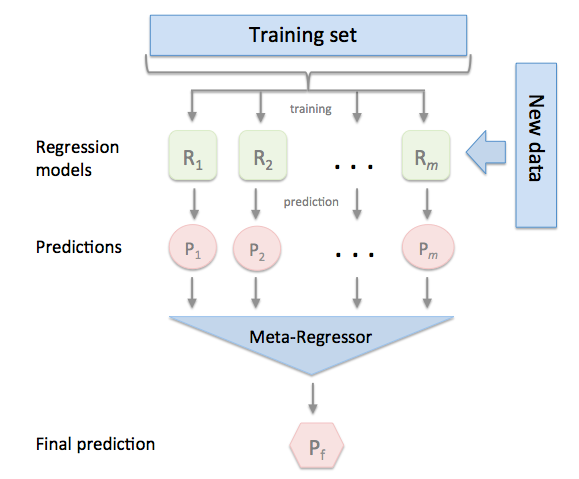

Hyperparamètres à évaluer :
* Régularisation C de l'estimateur SVR
* Régularisation alpha de l'estimateur Ridge
* n_estimators de l'estimateur final RandomForestRegressor

In [ ]:
# chargement des datasets
X_train_SR = X_train_final.copy()
X_test_SR = X_test_final.copy()
y_train_SR = y_train_final.copy()
y_test_SR = y_test_final.copy()

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(random_state=22)),
              ('ridge', Ridge(random_state=22))
             ]

In [ ]:
# application preprocessor et modèle
SR_model = Pipeline([('preprocessor', preprocessor), 
                     ('stacking_regressor', StackingRegressor(estimators=estimators,
                                                              final_estimator=RandomForestRegressor(random_state=22)))])

In [ ]:
# entrainement sur le jeu d'entrainement
SR_model.fit(X_train_SR, y_train_SR)
train_r2(SR_model, X_train_SR, y_train_SR)

In [ ]:
# prediction sur le jeu de test
y_pred_SR = SR_model.predict(X_test_SR)
test_r2(y_test_SR, y_pred_SR)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_SR = cross_val_score(SR_model, X, y, cv=5)
print(f"Cross_Validation : {score_SR}")

**Commentaires :**  
* Scores Train et test équivalent à 0.64
* Cross_validation varie entre 0.20 et 0.48

**Comparaison optimisation par GridSearchCV Vs RandomSearchCV:**

In [ ]:
param_stacking = {
    'stacking_regressor__svr_lin__C': [0.01, 0.1, 1, 10],
    'stacking_regressor__ridge__alpha': [0.1, 1, 10, 20],
    'stacking_regressor__final_estimator__n_estimators': [10, 50, 100, 200],
}

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(random_state=22)),
              ('ridge', Ridge(random_state=22))
             ]

In [ ]:
SR_model = Pipeline([('preprocessor', preprocessor), ('stacking_regressor', StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=22)))])

**GridSearchCV :**

In [ ]:
# mesure du temps pour GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(estimator=SR_model, param_grid=param_stacking, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_SR, y_train_SR)
end_time = time.time()
grid_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par GridSearchCV : {grid_search_time}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score (R^2) : {grid_search.best_score_}")

In [ ]:
best_params = grid_search.best_params_

best_estimators = [('lr', LinearRegression()),
                   ('svr_lin', LinearSVR(random_state=22, C=best_params['stacking_regressor__svr_lin__C'])),
                   ('ridge', Ridge(random_state=22, alpha=best_params['stacking_regressor__ridge__alpha']))
                  ]

best_final_estimator = RandomForestRegressor(random_state=22, n_estimators=best_params['stacking_regressor__final_estimator__n_estimators'])

In [ ]:
best_stacking_model = Pipeline([('preprocessor', preprocessor),
                                ('stacking_regressor', StackingRegressor(estimators=best_estimators, final_estimator=best_final_estimator))
                               ])

best_stacking_model.fit(X_train_SR, y_train_SR)
train_r2(best_stacking_model, X_train_SR, y_train_SR)

In [ ]:
# prediction sur le jeu de test
y_pred_SR_grid = best_stacking_model.predict(X_test_SR)
test_r2(y_test_SR, y_pred_SR_grid)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_SR_grid = cross_val_score(best_stacking_model, X, y, cv=5)
print(f"Cross_Validation : {score_SR_grid}")

**Commentaires :**  
* Scores équivalent avec optimisation
* Dégradation des scores de Cross_validation (entre 0.19 et 0.55)

In [ ]:
#plot_learning_curve(best_stacking_model, X, y)

**RandomSearchCV :**

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(random_state=22)),
              ('ridge', Ridge(random_state=22))
             ]

In [ ]:
# mesure temps optimisation de RandomSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(estimator=SR_model, param_distributions=param_stacking, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_SR, y_train_SR)
end_time = time.time()
random_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par RandomSearchCV : {random_search_time}")
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (R^2) : {random_search.best_score_}")

In [ ]:
best_params_random = random_search.best_params_

best_estimators_random = [('lr', LinearRegression()),
                          ('svr_lin', LinearSVR(random_state=22, C=best_params_random['stacking_regressor__svr_lin__C'])),
                          ('ridge', Ridge(random_state=22, alpha=best_params_random['stacking_regressor__ridge__alpha']))
                         ]

best_final_estimator_random = RandomForestRegressor(random_state=22,
                                             n_estimators=best_params_random['stacking_regressor__final_estimator__n_estimators']
                                            )

In [ ]:
best_stacking_model_random = Pipeline([('preprocessor', preprocessor), 
                                       ('stacking_regressor', StackingRegressor(estimators=best_estimators_random, final_estimator=best_final_estimator_random))
                                      ])

best_stacking_model_random.fit(X_train_SR, y_train_SR)
train_r2(best_stacking_model_random, X_train_SR, y_train_SR)

In [ ]:
# prediction sur le jeu de test
y_pred_SR_random = best_stacking_model_random.predict(X_test_SR)
test_r2(y_test_SR, y_pred_SR)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stablebbb/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_SR_random = cross_val_score(best_stacking_model_random, X, y, cv=5)
print(f"Cross_Validation : {score_SR_random}")

**Commentaires :**  
* Scores équivalents entre GridSearch et RandomSearch mais gain de temps pour ce dernier.

---
---
### 4.5 - Gradient Boosting Regressor :

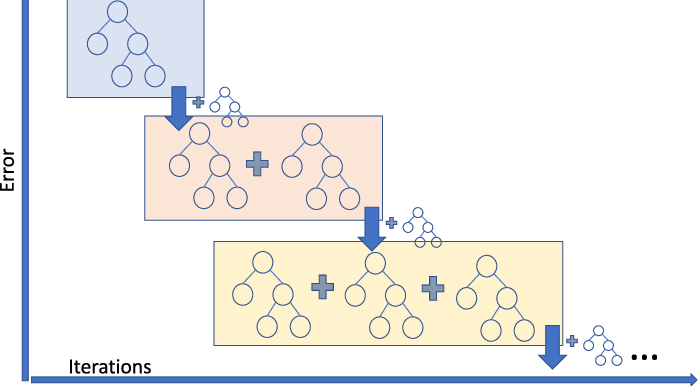

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# chargement des datasets
X_train_gbr = X_train_final.copy()
X_test_gbr = X_test_final.copy()
y_train_gbr = y_train_final.copy()
y_test_gbr = y_test_final.copy()

In [ ]:
gbr_model = Pipeline([('preprocessor', preprocessor), ('gbr', GradientBoostingRegressor(random_state=22))])

In [ ]:
gbr_model.fit(X_train_gbr, y_train_gbr)

In [ ]:
train_r2(gbr_model, X_train_gbr, y_train_gbr)

In [ ]:
# prediction sur le jeu de test
y_pred_gbr = gbr_model.predict(X_test_gbr)
test_r2(y_test_gbr, y_pred_gbr)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_gbr = cross_val_score(gbr_model, X, y, cv=5)
print(f"Cross_Validation : {score_gbr}")

**Commentaires :**  
* Léger surapprentissage 0.82 et 0.67
* Variation dans les scores de Cross_validation : de 0.40 à 0.68

**Comparaison optimisation par GridSearchCV Vs RandomSearchCV:**

In [ ]:
param_grid_bgr = {
    'gbr__n_estimators': [100, 200, 300],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 4, 5],
    'gbr__subsample': [0.8, 0.9, 1.0]
}

In [ ]:
gbr_model = Pipeline([('preprocessor', preprocessor), ('gbr', GradientBoostingRegressor(random_state=22))])

**GridSearchCV :**

In [ ]:
# mesure du temps pour GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid_bgr, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_gbr, y_train_gbr)
end_time = time.time()
grid_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par GridSearchCV : {grid_search_time}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score (R^2) : {grid_search.best_score_}")

In [ ]:
best_params_grid_gbr = grid_search.best_params_

best_gbr_model_grid = Pipeline([('preprocessor', preprocessor), 
                               ('gbr', GradientBoostingRegressor(n_estimators=best_params_grid_gbr['gbr__n_estimators'],
                                                                 learning_rate=best_params_grid_gbr['gbr__learning_rate'],
                                                                 max_depth=best_params_grid_gbr['gbr__max_depth'],
                                                                 subsample=best_params_grid_gbr['gbr__subsample'],
                                                                 random_state=22))])
best_gbr_model_grid.fit(X_train_gbr, y_train_gbr)
train_r2(best_gbr_model_grid, X_train_gbr, y_train_gbr)

In [ ]:
# prediction sur le jeu de test
y_pred_gbr_grid = best_gbr_model_grid.predict(X_test_gbr)
test_r2(y_test_gbr, y_pred_gbr_grid)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_gbr_grid = cross_val_score(best_gbr_model_grid, X, y, cv=5)
print(f"Cross_Validation : {score_gbr_grid}")

**Commentaires :**  
* Amélioration des scores - Test: 0.82 à 0.87 - Train: 0.67 à 0.69
* Augmentation de l'écart entre le Trai et le Test
* Variation importante des scores de Cross_validation : 0.41 à 0.67

In [ ]:
#plot_learning_curve(best_gbr_model_grid, X, y)

**RandomSearchCV :**

In [ ]:
# mesure temps optimisation de RandomSearchCV
start_time = time.time()
random_search = RandomizedSearchCV(estimator=gbr_model, param_distributions=param_grid_bgr, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_gbr, y_train_gbr)
end_time = time.time()
random_search_time = end_time - start_time

In [ ]:
print(f"Temps d'optimisation par RandomSearchCV : {random_search_time}")
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (R^2) : {random_search.best_score_}")

In [ ]:
best_params_random_gbr = grid_search.best_params_

best_gbr_model_random = Pipeline([('preprocessor', preprocessor), 
                               ('gbr', GradientBoostingRegressor(n_estimators=best_params_grid_gbr['gbr__n_estimators'],
                                                                 learning_rate=best_params_grid_gbr['gbr__learning_rate'],
                                                                 max_depth=best_params_grid_gbr['gbr__max_depth'],
                                                                 subsample=best_params_grid_gbr['gbr__subsample'],
                                                                 random_state=22))])
best_gbr_model_random.fit(X_train_gbr, y_train_gbr)
train_r2(best_gbr_model_random, X_train_gbr, y_train_gbr)

In [ ]:
# prediction sur le jeu de test
y_pred_gbr_random = best_gbr_model_random.predict(X_test_gbr)
test_r2(y_test_gbr, y_pred_gbr_random)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_gbr_random = cross_val_score(best_gbr_model_random, X, y, cv=5)
print(f"Cross_Validation : {score_gbr_random}")

**Commentaires :**  
* Scores équivalents entre GridSearch et RandomSearch mais gain de temps pour ce dernier.

---
---
### 4.6 - Choix du modèle et hyperparamètres 

Suite à l'étape précédente, ce qui en ressort :
* L'optimisation des modèles est chronophage
* Le RandomSearch est toujours plus rapide que le GridSearch
* Le RandomSearch est toujours très proche des résultats du GridSearch voir équivalent
* Chaque modèle montre un surapprentissage
* Chaque modèle donne des scores Cross_validation qui varient et toujours en dessous les scores Test

---
### 4.6.1 - Choix du modèle :

Le modèle qui offre le meilleur compromis entre les scores Train/Test, ainsi que les scores de Cross_validation est le modèle : **Stacking Regressor**,  
avec en estimateurs :
* LinearRegression
* LinearSVR avec C=1
* Ridge avec alpha =1

en final_estimator :
* RandomForestRegressor avec n_estimators=100

In [ ]:
# chargement des datasets
X_train_SR = X_train_final.copy()
X_test_SR = X_test_final.copy()
y_train_SR = y_train_final.copy()
y_test_SR = y_test_final.copy()

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(C=1, random_state=22)),
              ('ridge', Ridge(alpha=1, random_state=22))
             ]

In [ ]:
# application preprocessor et modèle
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=22))

SR_model = Pipeline([('preprocessor', preprocessor), 
                     ('stacking_regressor', stacking_regressor)])

In [ ]:
# entrainement sur le jeu d'entrainement
SR_model.fit(X_train_SR, y_train_SR)

In [ ]:
train_r2(SR_model, X_train_SR, y_train_SR)

In [ ]:
# prediction sur le jeu de test
y_pred_SR = SR_model.predict(X_test_SR)
test_r2(y_test_SR, y_pred_SR)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_SR = cross_val_score(SR_model, X, y, cv=5)
print(f"Cross_Validation : {score_SR}")

In [ ]:
#plot_learning_curve(SR_model, X, y)

---
---
---
## Etape 5 - Analyse de la "feature importance" globale et locale :

**Stratégie d'analyse :**  

Le modèle sélectionné est de type : **Stacking Regressor** (modèle d'ensemble qui utilise plusieurs modèles simples dont les prédictions servent à entrainer un modèle final).  

* Feature importance globale :
    -  Méthode `permutation_importance` *(explication des prédictions sur le jeu de **test**)*
    -  Méthode avec SHAP *(explication du modèle pendant l'entrainement)*
* Feature importance locale :
    - Méthode **SHAP** *(explication d'une prédiction en particulier lors de l'entrainement)*

---
---
### 5.1 - Feature Importance Globale :

#### 5.1.1 - Méthode `permutation_importance` :

**Rappel de la méthode:** Pour chaque feature, les valeurs de cette feature sont mélangées aléatoirement dans le jeu de test, la performance du modèle est mesurée sur ce jeu de test où une seule feature a été permutée et comparer à la performance du jeu original. ==> Une forte diminution de la performance indique que la feature est importante pour le modèle.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# recuperation des noms des features avec celles encodees sous forme de liste
feature_names = quantitative_features + log_transform_features + list(SR_model.named_steps['preprocessor'].named_transformers_['qual_OHE'].get_feature_names_out())

In [ ]:
# recuperation du modele stacking uniquement
pipe_model = SR_model.named_steps['stacking_regressor']

# Application du preprocessor sur le jeu de test - encodage des features
X_test_transformed = SR_model.named_steps['preprocessor'].transform(X_test_SR)
X_test_transformed_dense = X_test_transformed.toarray() 

# Permutation Importance
result = permutation_importance(pipe_model, X_test_transformed_dense, y_test_SR, n_repeats=10, random_state=22, n_jobs=-1)

In [ ]:
# mise en dataframe de la propriété permutation_importance
importances_df = pd.DataFrame()
for key in result:
    if key == 'importances':
        for j in range(result[key].shape[1]):
            importances_df[f'importances-{j + 1}'] = result[key][:, j]
    else:
        importances_df[key] = result[key]

importances_df.index = feature_names

**Affichage des 10 features les plus importants :**

In [ ]:
# affichage des 10 features les plus importantes
importances_df.abs().sort_values(by='importances_mean', ascending=False).head(10).iloc[:, [0]]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# trier les importances par les valeurs absolues
importances_abs = np.abs(result.importances_mean)
sorted_idx_perm_abs = np.argsort(importances_abs)[-20:]

# Boxplot for Permutation Importance
ax.boxplot(result.importances[sorted_idx_perm_abs].T, vert=False)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(np.arange(20) + 1)  
ax.set_yticklabels(np.array(feature_names)[sorted_idx_perm_abs])
ax.set_title("Top 20 - Permutation Importance (test set)")

# ajustement des marges
fig.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

**Commentaires :**  
* Des modifications dans la feature `PropertyGFABuilding(s)` créés les plus fortes variations dans le score de prédiction ==> cohérence d'une corrélation forte entre la consommation d'énergie et la surface totale des bâtiments en lien avec le chauffage/climatisation.
* Deuxième feature qui influe le plus, `PrimaryPropertyType_Supermarket / Grocery Store` : c'est une feature encoder en OneHotEncoder donc binaire, plus surprenant cette catégorie représente à peine 3% des catégories mais doit avoir des caractéristiques atypiques.
* La feature `NumberofFloors` influe beaucoup également
* La vingtaine de features suivantes ont une influence moyenne proche, au global n'apportent pas beaucoup plus d'informations, elles influent par catégories spécifiques, l'approche locale sera plus pertinente pour celles-ci.

---
#### 5.1.2 - Méthode avec utilisation de SHAP :

In [ ]:
import shap
from tqdm.autonotebook import tqdm
shap.initjs()

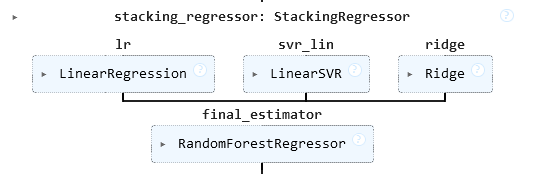

On ne peut pas passer directement un modèle `stacking_regressor` à SHAP, voici l'approche utilisée sur le jeu d'entrainement :
* Récupération des prédictions des estimateurs de base
* Création d'un explainer SHAP pour chaque estimateurs de base
* Calcul des valeurs SHAP pour chaque estimateurs de base
* Affichages par estimateurs de base
* Création d'un explainer SHAP pour l'estimateur final
* Calcul des valeurs SHAP de l'explainer final à partir des prédictions des estimateurs de base
* Affichage de l'estimateur final

In [ ]:
# application du preprocessor sur le train - encodage des features
X_train_transformed = SR_model.named_steps['preprocessor'].transform(X_train_SR)
X_train_transformed_dense = X_train_transformed.toarray() 

In [ ]:
# obtenir les predictions intermediaires des estimators de base
base_predictions = np.column_stack([est.predict(X_train_transformed_dense) for _, est in stacking_regressor.named_estimators_.items()])
# explainer SHAP pour chaque estimator de base
base_explainers = {name: shap.Explainer(est, X_train_transformed_dense) for name, est in stacking_regressor.named_estimators_.items()}
# calcul valeurs SHAP pour chaque estimator de base
base_shap_values = {name: explainer(X_train_transformed_dense) for name, explainer in base_explainers.items()}

In [ ]:
# explainer SHAP pour le modele final en utilisant les predictions des estimateurs de base
final_estimator = stacking_regressor.final_estimator_
final_explainer = shap.Explainer(final_estimator, base_predictions)
final_shap_values = final_explainer(base_predictions)

In [ ]:
# Visualiser les valeurs SHAP pour chaque estimator de base
for name, shap_values in base_shap_values.items():
    print(f"SHAP values for base estimator: {name}")
    shap.summary_plot(shap_values, X_train_transformed_dense, feature_names=feature_names)

# Visualiser les valeurs SHAP pour le modèle final
print("SHAP values for final estimator")
shap.summary_plot(final_shap_values, base_predictions, feature_names=[name for name, _ in stacking_regressor.named_estimators_.items()])

In [ ]:
# moyenne des valeurs SHAP des estimateurs de base pour une estimation combinée
combined_shap_values = np.mean([shap_values.values for shap_values in base_shap_values.values()], axis=0)

global_shap_values = np.zeros_like(combined_shap_values)

global_shap_values += combined_shap_values

for i, (name, _) in enumerate(stacking_regressor.named_estimators_.items()):
    global_shap_values += final_shap_values.values[:, i][:, np.newaxis] * base_shap_values[name].values

# Visualiser les valeurs SHAP globales pour une importance globale des features
shap.summary_plot(global_shap_values, X_train_transformed_dense, feature_names=feature_names)

**Commentaires :**  
* On retrouve ici la feature `PropertyGFABuilding(s)` en tant que plus influente.
* Par rapport à la méthode Permutation Importance, on retrouve ensuite les mêmes features mais dans un ordre différent. Nous sommes ici sur le jeu d'entrainement, d'où la différence.

---
---
### 5.1. - Feature Importance Locale :

#### 5.1.1 - Méthode avec SHAP :

Comme pour l'analyse globale, ici nous ne pouvons pas calculer directement les shap_values directement avec le modèle Stacking Regressor, une approche identique est utilisée sur le jeu de test :
* Récupération des prédictions des estimateurs de base
* Création d'un explainer SHAP pour chaque estimateurs de base
* Calcul des valeurs SHAP pour chaque estimateurs de base
* Création d'un explainer SHAP pour l'estimateur final
* Choisir l'élément à expliquer (`index_to_explain`)
* Réaliser les calculs pour l'élément
* Récupération des données d'origine pour interpréter
* Affichage explication SHAP


In [ ]:
# application du preprocessor sur le jeu de test - encodage des features
X_test_transformed = SR_model.named_steps['preprocessor'].transform(X_test_SR)
X_test_transformed_dense = X_test_transformed.toarray() 

# obtenir les predictions des estimators de base
base_predictions = np.column_stack([est.predict(X_test_transformed_dense) for _, est in stacking_regressor.named_estimators_.items()])
# creer un explainer SHAP pour chaque estimator de base
base_explainers = {name: shap.Explainer(est, X_test_transformed_dense) for name, est in stacking_regressor.named_estimators_.items()}
# calculer les valeurs SHAP pour chaque estimator de base
base_shap_values = {name: explainer(X_test_transformed_dense) for name, explainer in base_explainers.items()}

In [ ]:
# creer un explainer SHAP pour le modele final avec les predictions des estimators de base
final_estimator = stacking_regressor.final_estimator_
final_explainer = shap.Explainer(final_estimator, base_predictions)
final_shap_values = final_explainer(base_predictions)

In [ ]:
# choix de l'index pour analyse feature_importance locale
index_to_explain = 4

In [ ]:
# creer un tableau dela bonne taille avec des 0
local_shap_values = np.zeros_like(base_shap_values['lr'].values[0])

In [ ]:
# ajouter les valeurs SHAP des features 
for name in stacking_regressor.named_estimators_.keys():
    local_shap_values += base_shap_values[name].values[index_to_explain]

# ajouter les valeurs SHAP des predictions de base ponderees du final_estimator
for i, (name, _) in enumerate(stacking_regressor.named_estimators_.items()):
    local_shap_values += final_shap_values.values[index_to_explain, i] * base_shap_values[name].values[index_to_explain]

In [ ]:
# recuperer les donnees d'origine pour interpreter

# transformateurs fit
quantitative_transformer_fitted = SR_model.named_steps['preprocessor'].named_transformers_['quant']
log_and_scale_transformer_fitted = SR_model.named_steps['preprocessor'].named_transformers_['log_and_scale']
qualitative_transformer_fitted = SR_model.named_steps['preprocessor'].named_transformers_['qual_OHE']

# donnees transformees
sample_transformed = X_test_transformed_dense[index_to_explain]

# separer les transformations
num_features_len = quantitative_transformer_fitted.transform(X_test_SR[quantitative_features]).shape[1]
log_features_len = log_and_scale_transformer_fitted.transform(X_test_SR[log_transform_features]).shape[1]
cat_features_len = qualitative_transformer_fitted.transform(X_test_SR[qualitative_features_OHE]).shape[1]

num_transformed = sample_transformed[:num_features_len]
log_transformed = sample_transformed[num_features_len:num_features_len + log_features_len]
cat_transformed = sample_transformed[num_features_len + log_features_len:num_features_len + log_features_len + cat_features_len]

# inverser les transformations
num_original = quantitative_transformer_fitted.inverse_transform([num_transformed])
log_original = np.expm1(log_and_scale_transformer_fitted.named_steps['scaler'].inverse_transform([log_transformed]))
cat_original = qualitative_transformer_fitted.inverse_transform([cat_transformed])

# resultats en listes pour les inserer dictionnaire
num_original_list = num_original[0].tolist()
log_original_list = log_original[0].tolist()
cat_original_list = cat_original[0].tolist()

# dictionnaire
original_features_dict = {}

# features quantitatives
for i, feature in enumerate(quantitative_features):
    original_features_dict[feature] = num_original_list[i]

# features log
for i, feature in enumerate(log_transform_features):
    original_features_dict[feature] = log_original_list[i]

# features qualitatives
for i, feature in enumerate(qualitative_features_OHE):
    original_features_dict[feature] = cat_original_list[i]

# affichage en df
df_original_datas = pd.DataFrame.from_dict(original_features_dict, orient='index')
df_original_datas

In [ ]:
# affichage pour index_to_explain
shap.waterfall_plot(shap.Explanation(values=local_shap_values, base_values=final_shap_values.base_values[index_to_explain], data=X_test_transformed_dense[index_to_explain], feature_names=feature_names), show=False)
plt.gcf().set_size_inches(20, 10)
plt.show()

**Commentaires :**  
* Pour l'exemple ci-dessus, la feature qui augmente le plus le score est : `PropertyGFABuilding(s)`
* Les 2 autres qui augmentent le plsu également sont les usages "WorshipFacility"
* Celles qui font baissées le plus le score : `Latitude`, `ThirdLargestPropertyUseType_Not concerned`, `YearBuilt` et `BuildingAge`

---
---
---
## Etape 6 : Analyse de l'influence de l'EnergyStarScore

**Que représente l'EnergyStarScore ?**  

L'Energy Star Score est une note de 1 à 100 qui évalue l'efficacité énergétique d'un bâtiment par rapport à d'autres bâtiments similaires. Un score élevé signifie que le bâtiment est plus économe en énergie. Le score est important pour réduire les coûts, les émissions de carbone, et augmenter la valeur du bâtiment.

**Traitement des manquants de `EnergyStarScore` :**  

Nous savons que ce score est fastidieux à calculer, il intègre plusieurs aspects et peut ne pas avoir de simple relation linéaire avec les autres features.  
Il dépend de plusieurs features et ne peut donc pas se justifier par une imputation par la moyenne ou la médiane.  
Connaissant ces particularités, j'opte pour une imputation avec la méthode **KNN** à 5 voisins plus proches, qui sera réaliser pendant le **`preprocessor`** du pipeline.

---
### 6.1 - Nouveau dataset :

Afin d'ajouter la feature `EnergyStarScore` et afin de ne pas modifier les analyses précédentes, je créé un nouveau fichier EDA qui l'inclus :  
[NOUVEAU FICHIER EDA - 01.2_EDA_Target_1_EnergyStarScore](./01.2_EDA_Target_1_EnergyStarScore.ipynb)  

In [ ]:
# recuperation du dataset incluant EnergyStarScore
energy_df_ESS = pd.read_csv('data/cleaned/energy_df_EnergyStarScore.csv', index_col=0)

In [ ]:
# application du FE précédent
energy_df_ESS['UseTypesQty'] = energy_df_ESS['ListOfAllPropertyUseTypes'].apply(count_elements_str)

In [ ]:
energy_df_ESS = energy_df_ESS.drop(columns='ListOfAllPropertyUseTypes')

In [ ]:
# creation du dataset features
X_ESS = energy_df_ESS.drop(columns = 'target')
X_ESS.shape

In [ ]:
# creation du dataset target
y_ESS = energy_df_ESS.target
y_ESS.shape

In [ ]:
# diviser les donnees en jeux d'entrainement et test
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state=22)

---
---
### 6.2 - Modélisation :

#### 6.2.1 - Préparation du Pipeline :

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
# definir les colonnes quantitatives et qualitatives
quantitative_features = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'BuildingAge', 'ElectricityRate', 'GasRate', 'SteamRate', 'UseTypesQty', 'ENERGYSTARScore']
log_transform_features = ['PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
qualitative_features_OHE = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

In [ ]:
# standardisation des donnees
quantitative_transformer = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler())])

# fonction de transformation logarithmique de certains features
log_transformer = Pipeline([('log_transform', FunctionTransformer(np.log1p, validate=True))])

# pipeline pour realiser la transformation log puis standardisation
log_and_scale_transformer = Pipeline([('log_transform', log_transformer), ('scaler', StandardScaler())])

# encodage des variables qualitatives
qualitative_transformer_OHE = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

# appliquer l'encodage et la standardisation
preprocessor = ColumnTransformer(transformers=[('quant', quantitative_transformer, quantitative_features), ('log_and_scale', log_and_scale_transformer, log_transform_features), ('qual_OHE', qualitative_transformer_OHE, qualitative_features_OHE)]) 

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(C=1, random_state=22)),
              ('ridge', Ridge(alpha=1, random_state=22))
             ]

In [ ]:
# application preprocessor et modèle
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=22))

SR_model_ESS = Pipeline([('preprocessor', preprocessor), 
                     ('stacking_regressor', stacking_regressor)])

---
#### 6.2.2 - Entrainement du modèle :

In [ ]:
# entrainement sur le jeu d'entrainement
SR_model_ESS.fit(X_train_ESS, y_train_ESS)

In [ ]:
train_r2(SR_model_ESS, X_train_ESS, y_train_ESS)

In [ ]:
# prediction sur le jeu de test
y_pred_ESS = SR_model_ESS.predict(X_test_ESS)
test_r2(y_test_ESS, y_pred_ESS)

# classe ShuffleSplit trouvé sur la doc scikit-learn afin de comparer avec un cv=5 uù je trouve de grosses différences 
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=22)
score_ESS = cross_val_score(SR_model_ESS, X_ESS, y_ESS, cv=5)
print(f"Cross_Validation : {score_ESS}")

**Commentaires :**  
Amélioration du score avec cette nouvelle feature.  
Précédemment :  
```
Le R²_train pour ce modèle : 0.6423490922617354
Le R²_train ajusté pour ce modèle : 0.6360101302775684
Le R²_test pour ce modèle : 0.6483464673431264
Le R²_test ajusté pour ce modèle : 0.6421138021187974
Cross_Validation : [0.20016203 0.4901285  0.27532797 0.27788009 0.41422168]
```

---
#### 6.2.3 - Essai d'optimisation :

Avec cette nouvelle feature, je tente une optimisation par `RandomSearchCV` afin d'évaluer s'il est possible d'améliorer le score.

In [ ]:
param_stacking_ESS = {
    'preprocessor__quant__imputer__n_neighbors': [3, 5, 7, 9], 
    'stacking_regressor__svr_lin__C': [0.01, 0.1, 1, 10],
    'stacking_regressor__ridge__alpha': [0.1, 1, 10, 20],
    'stacking_regressor__final_estimator__n_estimators': [10, 50, 100, 200],
}

In [ ]:
estimators = [('lr', LinearRegression()),
              ('svr_lin', LinearSVR(random_state=22)),
              ('ridge', Ridge(random_state=22))
             ]

In [ ]:
SR_model_random_ESS = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking_regressor', StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=22)))
])

In [ ]:
# optimisation de RandomSearchCV
random_search = RandomizedSearchCV(estimator=SR_model_random_ESS, param_distributions=param_stacking_ESS, cv=5, n_jobs=-1, scoring='r2')
random_search.fit(X_train_ESS, y_train_ESS)

In [ ]:
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")

In [ ]:
# standardisation des donnees
quantitative_transformer = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler())])

# appliquer l'encodage et la standardisation
preprocessor = ColumnTransformer(transformers=[('quant', quantitative_transformer, quantitative_features), ('log_and_scale', log_and_scale_transformer, log_transform_features), ('qual_OHE', qualitative_transformer_OHE, qualitative_features_OHE)]) 

best_estimators_random = [('lr', LinearRegression()),
                          ('svr_lin', LinearSVR(random_state=22, C=0.1)),
                          ('ridge', Ridge(random_state=22, alpha=20))
                         ]

best_final_estimator_random = RandomForestRegressor(random_state=22,
                                             n_estimators=100
                                            )

In [ ]:
best_model_random = Pipeline([('preprocessor', preprocessor), 
                                       ('stacking_regressor', StackingRegressor(estimators=best_estimators_random, final_estimator=best_final_estimator_random))
                                      ])

best_model_random.fit(X_train_ESS, y_train_ESS)
train_r2(best_model_random, X_train_ESS, y_train_ESS)

In [ ]:
# prediction sur le jeu de test
y_pred_random = best_model_random.predict(X_test_ESS)
test_r2(y_test_ESS, y_pred_random)

score_random = cross_val_score(best_model_random, X_ESS, y_ESS, cv=5)
print(f"Cross_Validation : {score_random}")

**Commentaires :**  
Nouvelle amélioration interessante, les scores train et Test augmentent et sont très proches.

---
---
### 6.3 - Analyse de l'influence de l'Energy Star Score :

#### 6.3.1 - Feature Importance Globale avec `Permutation_importance` :

In [ ]:
# recuperation des noms des features avec celles encodees sous forme de liste
feature_names_ESS = quantitative_features + log_transform_features + list(best_model_random.named_steps['preprocessor'].named_transformers_['qual_OHE'].get_feature_names_out())

In [ ]:
# recuperation du modele stacking uniquement
pipe_model_ESS = best_model_random.named_steps['stacking_regressor']

# Application du preprocessor sur le jeu de test - encodage des features
X_test_transformed_ESS = best_model_random.named_steps['preprocessor'].transform(X_test_ESS)
X_test_transformed_dense_ESS = X_test_transformed_ESS.toarray() 

# Permutation Importance
result_ESS = permutation_importance(pipe_model_ESS, X_test_transformed_dense_ESS, y_test_ESS, n_repeats=10, random_state=22, n_jobs=-1)

In [ ]:
# mise en dataframe de la propriété permutation_importance
importances_df_ESS = pd.DataFrame()
for key in result:
    if key == 'importances':
        for j in range(result[key].shape[1]):
            importances_df_ESS[f'importances-{j + 1}'] = result_ESS[key][:, j]
    else:
        importances_df_ESS[key] = result_ESS[key]

importances_df_ESS.index = feature_names_ESS

# affichage des 10 features les plus importantes
importances_df_ESS.abs().sort_values(by='importances_mean', ascending=False).head(10).iloc[:, [0]]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# trier les importances par les valeurs absolues
importances_abs_ESS = np.abs(result_ESS.importances_mean)
sorted_idx_perm_abs_ESS = np.argsort(importances_abs_ESS)[-20:]

# Boxplot for Permutation Importance
ax.boxplot(result_ESS.importances[sorted_idx_perm_abs_ESS].T, vert=False)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(np.arange(20) + 1)  
ax.set_yticklabels(np.array(feature_names_ESS)[sorted_idx_perm_abs_ESS])
ax.set_title("Top 20 Permutation Importance (test set)")

# ajustement des marges
fig.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

**Commentaires :**  
On observe que la feature `EnergyStarScore` a une forte influence sur le score, elle est la deuxième plus significative.

---
#### 6.3.2 - Etude corrélations des features :

**corrélation du dataset passé par le Feature Engineering mais sans l'imputation :**

In [ ]:
correlation_matrix = energy_df_ESS.select_dtypes(exclude='object').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Energy Use Variables')
#plt.savefig('temp.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

**Commentaires :**  
Je cherche ici à vérifier s'il existe des corrélations linéaires entre `ENERGYSTARScore` et la target ou les autres features.  
Une légère corrélation de 0,24 avec `PropertyGFABuildings`.  
Cela confirme que sa relation avec les autres features n'est pas simplement linéaire.

**corrélation du dataset passé par le preprocessor et l'imputation :**

In [ ]:
# appliquer le preprocessing sur les données completes
X_ESS_preprocessed = best_model_random.named_steps['preprocessor'].transform(X_ESS)
# suite erreur pour realiser le dataframe, passage en matrice dense
X_ESS_preprocessed_dense = X_ESS_preprocessed.todense()

# dataframe
X_ESS_preprocessed_df = pd.DataFrame(X_ESS_preprocessed_dense, columns=feature_names_ESS)

In [ ]:
# selection des features de base sans l'encodage
quantitative_features_all = quantitative_features + log_transform_features
X_ESS_preprocessed_quantitative = X_ESS_preprocessed_df[quantitative_features_all]

correlation_matrix = X_ESS_preprocessed_quantitative.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Energy Use Variables')
#plt.savefig('temp.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

**Commentaires :**  
En comparant les corrélations avant et après Imputation, j'essaie de vérifier qu'il n'y ai pas eu de biais intégré.  
| Feature                              | Avant Imputation | Après Imputation | Différence |
|--------------------------------------|------------------|------------------|------------|
| PropertyGFABuilding(s)               | 0.24             | 0.09             | -0.15      |
| SecondLargestPropertyUseTypeGFA      | 0.18             | 0.11             | -0.07      |
| ThirdLargestPropertyUseTypeGFA       | 0.03             | 0.06             | +0.03      |
| BuildingAge                          | 0.08             | 0.03             | -0.05      |
| ElectricityRate                      | 0.14             | 0.09             | -0.05      |
| GasRate                              | 0.09             | 0.05             | -0.04      |

On constate une baisse de corrélation de -0.15 avec la feature `PropertyGFABuilding(s)`, cette différence indique une légère influence due à l'imputation, mais rien de catastrophique.


---
#### 6.3.3 - Conclusion sur l'influence de l'Energy Star Score :

| Metric                          | Avant                                | Après                                |
|---------------------------------|--------------------------------------|--------------------------------------|
| R²_train                        | 0.6423                               | 0.7324                               |
| R²_train ajusté                 | 0.6360                               | 0.7274                               |
| R²_test                         | 0.6483                               | 0.7216                               |
| R²_test ajusté                  | 0.6421                               | 0.7166                               |
| Cross_Validation (moyenne)      | 0.3315                               | 0.4302                               |
| Cross_Validation (détail)       | [0.2002 0.4901 0.2753 0.2779 0.4142] | [0.2366 0.6068 0.3200 0.3945 0.5931] |


L'influence de l'EnergyStar Score pour les prédictions de notre target 1 "SiteEnergyUse(kBtu)" est significative (Train : +0.09 | Test : +0.07 | CV_mean : +0.1).  
C'est une amélioration que l'on pouvait attendre étant donné que ce score est basé sur la consommation d'énergies.

---
---
---
## Etape 7 : Simulation de la 2ème target

Le travail sur la 2ème target a été réalisé en parallèle de de la 1ère, et se trouve sur les notebooks estampillé **Target_2**.

---
---
---
# Conclusion :

Pour l'objectif de se passer des relevés de consommation annuels et pouvoir réaliser des prédictions sur tout autre bâtiment, nous avons ici un modèle de départ qui fonctionne si nous n'avons pas besoin de trop de précision.  
Il serait par contre intéressant de réaliser les prédictions par tranches (ex: conso entre 1000 et 1500 kBtu), ce qui rendrait le modèle tout à fait pertinent.  

Il reste toutefois perfectible :
* ajout de données
* amélioration Feature Engineering (travail supplémentaire avec Importance Feature)